## 1. Problem Understanding and Information Gathering

### The first step I take is to know what is the problem then start gathering all the information from the dataset and figure out the solution.          
### The problem is credit risk prediction
### I will build the model to rank loan application based on credit behavior and the application 
### The result is loan application ranking from very low risk to very high risk




## 2. Read the csv file

In [ ]:
# Read CSV file
import pandas as pd
import numpy as np
inst = pd.read_csv('/content/drive/My Drive/Credit/installment_payment.csv')
prev = pd.read_csv('/content/drive/My Drive/Credit/prev_app.csv')
test = pd.read_csv('/content/drive/My Drive/Credit/app_test.csv')
train = pd.read_csv('/content/drive/My Drive/Credit/app_train.csv')

## 3. Data Preprocessing







### 3.1. Determine the credit behavior (No need to run)

Credit behavior is one of feature that i choose because it is used in real world and increase the risk model perfomance

In [ ]:
# Check duplicate
inst_dup = inst[inst.duplicated()] 
print(inst_dup)

Empty DataFrame
Columns: [Unnamed: 0, SK_ID_PREV, LN_ID, INST_NUMBER, INST_DAYS, PAY_DAYS, AMT_INST, AMT_PAY]
Index: []


There is no duplicate in installment csv

In [ ]:
# Check null and dtype info
inst.info(null_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872306 entries, 0 to 2872305
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Unnamed: 0   2872306 non-null  int64  
 1   SK_ID_PREV   2872306 non-null  int64  
 2   LN_ID        2872306 non-null  int64  
 3   INST_NUMBER  2872306 non-null  int64  
 4   INST_DAYS    2872306 non-null  float64
 5   PAY_DAYS     2871633 non-null  float64
 6   AMT_INST     2872306 non-null  float64
 7   AMT_PAY      2871633 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 175.3 MB


There is some null values in this data, I assume this missing values happen because the borrower run away, died, etc. So i will treat this missing value same as the loaner didnt 
pay and fill it with zero

Then I build algorithm to determine the credit behavior. I consider the behavior is bad when

1. If the PAY_DAYS overlap the INST_DAYS by more than 30 days

2. If the AMT_INST bigger than AMT_PAY 


In [ ]:
# Fill and sort inst csv
inst = inst.fillna(value=0)
inst = inst.sort_values(by=['LN_ID']) 

# Make array and list contain unique iD
inst_arr = np.array(inst[['SK_ID_PREV','LN_ID','INST_NUMBER','INST_DAYS','PAY_DAYS','AMT_INST','AMT_PAY']])
list = inst.LN_ID.unique()
list.sort()

In [ ]:
# Calculate credit behavior
inst_cb = np.array([[0,0]])
total = np.array([[0]])
k = 0
for i in list: 
  a = 0
  b = 0
  c = 0
  for j in range(k,inst_arr.shape[0]):
    if inst_arr[j,1] == i:
      if inst_arr[j,3] - inst_arr[j,4] < -30:
        a = a + 1
        c = c + 1
        k = k + 1
      else:
        c = c + 1
        k = k + 1
      if inst_arr[j,-1] < inst_arr[j,-2]:
        b = b + 1
      else:
        None
    else:
      break
  total = np.concatenate([total,np.array([[c]])])
  inst_cb = np.concatenate([inst_cb,np.array([[a,b]])])
feat_cb = inst_cb/total

In [ ]:
credit_behavior = np.zeros([feat_cb.shape[0]-1,2])
for i in range(1,feat_cb.shape[0]):
  credit_behavior[i-1,1] = feat_cb[i,0]+feat_cb[i,1]
  credit_behavior[i-1,0] = list[i-1]

The result is credit_behavior matrix that contain credit behavior and id number

### 3.2 Select credit behavior based on train and test id (No need to run)

I seperate and save this into csv because the running time is a little bit long

In [ ]:
train = train.sort_values(by=['LN_ID'])
test = test.sort_values(by=['LN_ID'])
id_train = np.array(train['LN_ID'])
id_test = np.array(test['LN_ID'])
def extract_cb(data):
  data_cb = np.zeros([data.shape[0],1])
  for i in range(data.shape[0]):
    for j in range(credit_behavior.shape[0]):
      if data[i] != credit_behavior[j,0]:
        None
      else:
        data_cb[i,0] = credit_behavior[j,1]
        break
  return data_cb

train_cb = extract_cb(id_train)
test_cb = extract_cb(id_test)

In [ ]:
np.savetxt("train_cb.csv", train_cb, delimiter=",")
np.savetxt("test_cb.csv", test_cb, delimiter=",")

The result is train_cb.csv and test_cb.csv that contain credit behavior for train and test 

### 3.3. Examine test.csv and train.csv


In [ ]:
# Check nulll and dtype
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61503 entries, 789 to 2528
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         61503 non-null  int64  
 1   LN_ID              61503 non-null  int64  
 2   TARGET             61503 non-null  int64  
 3   CONTRACT_TYPE      61503 non-null  object 
 4   GENDER             61503 non-null  object 
 5   NUM_CHILDREN       61503 non-null  int64  
 6   INCOME             61503 non-null  float64
 7   APPROVED_CREDIT    61503 non-null  float64
 8   ANNUITY            61502 non-null  float64
 9   PRICE              61441 non-null  float64
 10  INCOME_TYPE        61503 non-null  object 
 11  EDUCATION          61503 non-null  object 
 12  FAMILY_STATUS      61503 non-null  object 
 13  HOUSING_TYPE       61503 non-null  object 
 14  DAYS_AGE           61503 non-null  int64  
 15  DAYS_WORK          61503 non-null  int64  
 16  DAYS_REGISTRATION  61

In [ ]:
train.corr()

,Unnamed: 0,LN_ID,TARGET,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
Unnamed: 0,1.000000,0.999999,0.003167,-0.004230,0.007123,0.000194,0.002940,0.000655,-0.002353,0.000448,-0.005554,-0.003076,-0.002203,-0.005550,0.004905,0.004455
LN_ID,0.999999,1.000000,0.003173,-0.004228,0.007124,0.000192,0.002940,0.000653,-0.002354,0.000448,-0.005554,-0.003073,-0.002198,-0.005554,0.004900,0.004451
TARGET,0.003167,0.003173,1.000000,0.018525,-0.020814,-0.039372,-0.019047,-0.047927,0.083524,-0.049952,0.039037,0.055748,-0.029929,-0.175235,-0.159431,-0.182254
NUM_CHILDREN,-0.004230,-0.004228,0.018525,1.000000,0.021530,0.007365,0.027297,0.003395,0.331271,-0.240094,0.178593,-0.036734,-0.009091,-0.136222,-0.018246,-0.040431
INCOME,0.007123,0.007124,-0.020814,0.021530,1.000000,0.279659,0.351515,0.285695,0.050382,-0.116870,0.053163,0.017501,0.064925,0.062803,0.120227,-0.063953
APPROVED_CREDIT,0.000194,0.000192,-0.039372,0.007365,0.279659,1.000000,0.771021,0.987017,-0.049237,-0.071783,0.014528,-0.007247,0.052435,0.173309,0.132126,0.045288
ANNUITY,0.002940,0.002940,-0.019047,0.027297,0.351515,0.771021,1.000000,0.775949,0.015771,-0.111407,0.045753,0.010125,0.052041,0.117709,0.126223,0.032916
PRICE,0.000655,0.000653,-0.047927,0.003395,0.285695,0.987017,0.775949,1.000000,-0.048012,-0.069038,0.016497,-0.009235,0.062385,0.180624,0.140536,0.049573
DAYS_AGE,-0.002353,-0.002354,0.083524,0.331271,0.050382,-0.049237,0.015771,-0.048012,1.000000,-0.619288,0.324025,0.269007,0.088924,-0.601844,-0.089171,-0.204586
DAYS_WORK,0.000448,0.000448,-0.049952,-0.240094,-0.116870,-0.071783,-0.111407,-0.069038,-0.619288,1.000000,-0.206267,-0.271564,-0.087539,0.292186,-0.025813,0.115699


There is 16 numeric variable, 8 categorical variable, and several null values in ANNUITY, PRICE, EXT_SCORE_1,2,3.    
The null PRICE happen because the CONTRACT_TYPE is revolving loans so there is no actual price.      
I ignore the null PRICE and I will use the approved value instead because the correlation coef between these two is big and Im not missing any info about revolving loans.     
I will remove the row that have null ANNUITY values because its only one data and for the EXT_SCORE I will replace it with its mean because EXT_SCORE have big correlation coef value.





In [ ]:
# Remove row train .csv based on ANNUITY null
a = []
train_null = np.array(pd.isnull(train["ANNUITY"]))
for i in range(train_null.shape[0]):
  if train_null[i] == 1:
    a = np.concatenate([a,np.array([i])])
train = train.drop(a,axis=0)

In [ ]:
# Check nulll and dtype
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14761 entries, 8135 to 3527
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         14761 non-null  int64  
 1   LN_ID              14761 non-null  int64  
 2   TARGET             14761 non-null  int64  
 3   CONTRACT_TYPE      14761 non-null  object 
 4   GENDER             14761 non-null  object 
 5   NUM_CHILDREN       14761 non-null  int64  
 6   INCOME             14761 non-null  float64
 7   APPROVED_CREDIT    14761 non-null  float64
 8   ANNUITY            14761 non-null  float64
 9   PRICE              14741 non-null  float64
 10  INCOME_TYPE        14761 non-null  object 
 11  EDUCATION          14761 non-null  object 
 12  FAMILY_STATUS      14761 non-null  object 
 13  HOUSING_TYPE       14761 non-null  object 
 14  DAYS_AGE           14761 non-null  int64  
 15  DAYS_WORK          14761 non-null  int64  
 16  DAYS_REGISTRATION  1

There is null in EXT_SCORE 1,2,3 and I will deal with same like in train.csv

### 3.4 Data transformation, scaling and removing outliers

In [ ]:
# Sort train and test by id
train = train.sort_values(by=['LN_ID'])
test = test.sort_values(by=['LN_ID'])

# load train_cb and test_cb
train_cb = pd.read_csv('/content/drive/My Drive/Credit/train_cb.csv', header=None) 
test_cb = pd.read_csv('/content/drive/My Drive/Credit/test_cb.csv', header=None)

In [ ]:
# One Hot Encoding
from sklearn import preprocessing
def encode_string(cat_features):
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ohe = preprocessing.OneHotEncoder(categories = 'auto')
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

# Apply OHE and make feature label array
categorical_columns = ['FAMILY_STATUS','HOUSING_TYPE']
feature_train = encode_string(train['GENDER'])
feature_test = encode_string(test['GENDER'])

for col in categorical_columns:
    temp1 = encode_string(train[col])
    temp2 = encode_string(test[col])
    feature_train = np.concatenate([feature_train, temp1], axis = 1)
    feature_test = np.concatenate([feature_test, temp2], axis = 1)
    print(feature_train.shape[1],feature_test.shape[1])
    if  feature_train.shape[1] != feature_test.shape[1]:
      print(col)
feature_train = np.concatenate([feature_train, np.array(train[['NUM_CHILDREN','INCOME','ANNUITY', 'APPROVED_CREDIT',
                                                    'DAYS_AGE','EXT_SCORE_1','EXT_SCORE_2','EXT_SCORE_3']])], axis = 1)
feature_test = np.concatenate([feature_test, np.array(test[['NUM_CHILDREN','INCOME','ANNUITY', 'APPROVED_CREDIT',
                                                    'DAYS_AGE','EXT_SCORE_1','EXT_SCORE_2','EXT_SCORE_3']])], axis = 1)
train_label = np.array(train["TARGET"])
test_label = np.array(test["TARGET"])
print(feature_train.shape)
print(feature_test.shape)

7 7
13 13
(61502, 21)
(14761, 21)


FEATURE INDEX: 

GENDER : 0-1   
FAMILY STATUS : 2-6   
HOUSING TYPE : 7-12     
NUM_CHILDREN : 13    
INCOME : 14    
ANNUITY : 15   
APPROVED CREDIT : 16  
DAYS_AGE : 17   
EXT_SCORE1,2,3 : 18,19,20

I choose the feature above based on trial error, correlation coef and main logic about credit risk, I dont include all because it is not significant to the model perfomance

In [ ]:
# Check label count
from collections import Counter
counter = Counter(train_label)
print(counter)

Counter({0: 56533, 1: 4969})


The label 1 count is below 10% of the datatset. So this condition called imbalanced dataset.

In [ ]:
# Replacing nan in EXT_SCORE with mean
def replace_nan(feature):
  a1 = 0
  b1 = 0
  a2 = 0
  b2 = 0
  a3 = 0
  b3 = 0
  for i in range(feature.shape[0]):
    if np.isnan(feature[i,-1]) == 1:
      b1 = b1 + 1
    else:
      a1 = a1 + feature[i,-1]
      b1 = b1 + 1
    if np.isnan(feature[i,-2]) == 1:
      b2 = b2 + 1
    else:
      a2 = a2 + feature[i,-2]
      b2 = b2 + 1
    if np.isnan(feature[i,-3]) == 1:
      b3 = b3 + 1
    else:
      a3 = a3 + feature[i,-3]
      b3 = b3 + 1
  m1 = a1/b1
  m2 = a2/b2
  m3 = a3/b3
  for i in range(feature.shape[0]):
    if np.isnan(feature[i,-1]) == 1:
      feature[i,-1] = m1
    else:
      None
    if np.isnan(feature[i,-2]) == 1:
      feature[i,-2] = m2
    else:
      None
    if np.isnan(feature[i,-3]) == 1:
      feature[i,-3] = m3
    else:
      None
  return feature

feature_train = replace_nan(feature_train)
feature_test = replace_nan(feature_test)

In [ ]:
np.any(np.isnan(feature_test))

False

In [ ]:
np.any(np.isnan(feature_train))

True

There is no null values again in both feature test and train.

In [ ]:
# Add credit behavior to feature
feature_train = np.concatenate([feature_train, train_cb], axis = 1)
feature_test = np.concatenate([feature_test, test_cb], axis = 1)

Next step is transforming:
1. INCOME, ANNUITY into annuity to income ratio
2. ANNUITY, APPROVED_CREDIT into credit duration
3. DAYS_AGE into age in year
4. Deleting the APPROVED CREDIT because ratio and duration is enough to represent it

In [ ]:
# Transform feature to more simple form
def variable_transform(feature):
  for i in range(feature.shape[0]):
    feature[i,14] = feature[i,15]/feature[i,14]
    feature[i,15] = feature[i,16]/feature[i,15]
    feature[i,17] = int(feature[i,17]/-360)
  feature = np.delete(feature, 16, axis=1)
  return feature
  
feature_test = variable_transform(feature_test)
feature_train = variable_transform(feature_train)

In [ ]:
# Scaling 
scaler = preprocessing.StandardScaler().fit(feature_train)
feature_train = scaler.transform(feature_train)
feature_test = scaler.transform(feature_test)

Scaling is an important step in data preprocessing. The purpose of scaling is to balance feature values, because some model is tend to weigh greater values and ignore the small values.  
I choose StandardScaler as my scaling method because StandardScaler using the z score  that can help detect outliers and its important

And the next step should be remove outliers. Outliers are data that extreme value differ from other, so it can make the model confuse and misfit the prediction.     
Im using the zscore that obtained before. If the values greater than  +-3 i considered a outliers, because a value greater than +-3 it means the probability of occuring is very small.
But i find the test.csv contain outlier too so i decided not too remove it

### 3.5 Oversampling

Oversampling is a method to solve imbalanced dataset by raising the minority data.     
One of the oversampling method is SMOTE, SMOTE work based on k-NN and create sythetic data from it.    
I choose this method because it is better compared with custom weighting by trial and error.

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
over = SMOTE(random_state=12, ratio = 1.0)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
feature_train1, train_label1 = pipeline.fit_resample(feature_train, train_label)
counter = Counter(train_label1)
print(counter)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 56533, 1: 56533})


## 4. Risk Model and result

In [ ]:
import sklearn.metrics as sklm
from sklearn.ensemble import RandomForestClassifier

def print_metrics(label, scores):
        conf = sklm.confusion_matrix(label, scores)
        print('             Confusion matrix')
        print('             Score 0   Score 1')
        print('Actual 0   %6d' % conf[0,0] + '      %5d' % conf[0,1])
        print('Actual 1   %6d' % conf[1,0] + '      %5d' % conf[1,1])
        print('')
        print('Accuracy    = %0.3f' % sklm.accuracy_score(label, scores))
        print('Recall      = %0.3f' % sklm.recall_score(label, scores))
        tn, fp, fn, tp = sklm.confusion_matrix(label, scores).ravel()
        sensitive = tn / (tn+fp)
        print('Sensitivity = %0.3f' % sensitive)
        false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(label, scores)
        print('AUC Score   = %0.3f' % sklm.auc(false_positive_rate, true_positive_rate))

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(feature_train1,train_label1)
train_pred = rf.predict(feature_train1)
test_pred = rf.predict(feature_test)
print_metrics(test_label,test_pred)

             Confusion matrix
             Score 0   Score 1
Actual 0     9572       3986
Actual 1      416        787

Accuracy    = 0.702
Recall      = 0.654
Sensitivity = 0.706
AUC Score   = 0.680


## 5. Rank Decision

### 5.1 Costumer Clustering

In [ ]:
def rank(feature):
  feature_rank = np.zeros((feature.shape[0],3))
  feature_rank[:,0] = feature[:,15]
  feature_rank[:,1] = feature[:,20]
  return feature_rank

feature_rank_train = rank(feature_train)
feature_rank_test = rank(feature_test)

In [ ]:
mean1 = np.mean(feature_rank_train[:,0])
mean2 = np.mean(feature_rank_train[:,1])
sd1 = np.std(feature_rank_train[:,0])/2
sd2 = np.std(feature_rank_train[:,1])/2
def classify_rank(feature):
  for i in range(feature.shape[0]):
    if feature[i,0] <= mean1-sd1 and feature[i,1] <= mean2-sd2:
      feature[i,2] = 0
    elif feature[i,0] >= mean1+sd1 and feature[i,1] >= mean2+sd2:
      feature[i,2] = 1
    else:
      feature[i,2] = 2
  return feature

feature_rank_test = classify_rank(feature_rank_test)

<function matplotlib.pyplot.plot>

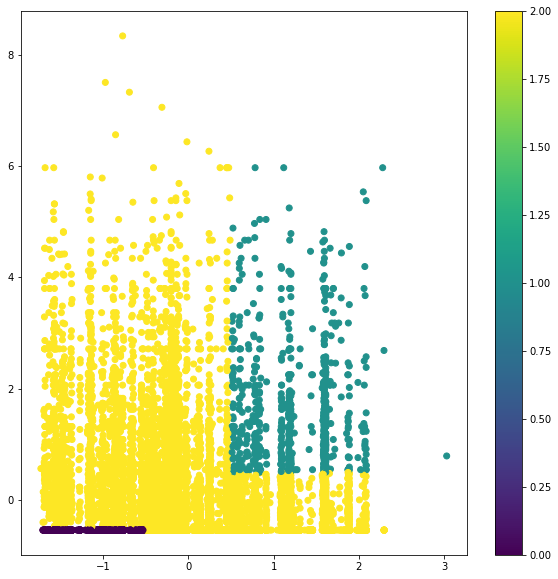

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(feature_rank_test[:,0], feature_rank_test[:,1], c=feature_rank_test[:,2], label=feature_rank_test[:,2])
plt.colorbar()
plt.plot

### 5.2 Decision Result

In [ ]:
q1, q2, q0 = 0, 0, 0
for i in range(test_pred.shape[0]):
    if feature_rank_test[i,2] == 1:
      q1 = q1 + test_pred[i]
    elif feature_rank_test[i,2] == 2:
      q2 = q2 + test_pred[i]
    else:
      q0 = q0 + test_pred[i]

In [ ]:
sum = feature_rank_test[:,2]
counter = Counter(sum.reshape([-1]))
print(counter)

Counter({2.0: 11634, 0.0: 2452, 1.0: 675})


In [ ]:
print('Cluster 0, Predict 1 = {}, Predict 0 = {}'.format(q0, counter[0]-q0))
print('Cluster 1, Predict 1 = {}, Predict 0 = {}'.format(q1, counter[1]-q1))
print('Cluster 2, Predict 1 = {}, Predict 0 = {}'.format(q2, counter[2]-q2))

Cluster 0, Predict 1 = 605, Predict 0 = 1847
Cluster 1, Predict 1 = 249, Predict 0 = 426
Cluster 2, Predict 1 = 3919, Predict 0 = 7715


In [ ]:
rank_list = []
for i in range(test_pred.shape[0]):
  if feature_rank_test[i,2] == 0 and test_pred[i] == 0:
    rank_list.append('Very Low risk')
  elif feature_rank_test[i,2] == 0 and test_pred[i] == 1:
    rank_list.append('Low Risk')
  elif feature_rank_test[i,2] == 1 and test_pred[i] == 0:
    rank_list.append('High Risk')
  elif feature_rank_test[i,2] == 1 and test_pred[i] == 1:
    rank_list.append('Very High Risk')
  elif feature_rank_test[i,2] == 2 and test_pred[i] == 0:
    rank_list.append('Medium Risk')
  else:
    rank_list.append('Medium Risk')

In [ ]:
rank_list = np.array([rank_list])
rank_decision = np.array([test['LN_ID']])
rank_decision.reshape([-1,1])
rank_list.reshape([-1,1])

array([['Medium Risk'],
       ['Medium Risk'],
       ['Medium Risk'],
       ...,
       ['Medium Risk'],
       ['Medium Risk'],
       ['Very Low risk']], dtype='<U14')

In [ ]:
rank_decision = np.concatenate([rank_decision,rank_list])

In [ ]:
rank_decision.reshape([-1,2])

array([['100054', '100081'],
       ['100100', '100131'],
       ['100135', '100136'],
       ...,
       ['Very Low risk', 'Very Low risk'],
       ['Medium Risk', 'Medium Risk'],
       ['Medium Risk', 'Very Low risk']], dtype='<U21')

In [ ]:
rank_decision_df = pd.DataFrame(data = rank_decision)

In [ ]:
rank_decision_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14721,14722,14723,14724,14725,14726,14727,14728,14729,14730,14731,14732,14733,14734,14735,14736,14737,14738,14739,14740,14741,14742,14743,14744,14745,14746,14747,14748,14749,14750,14751,14752,14753,14754,14755,14756,14757,14758,14759,14760
0,100054,100081,100100,100131,100135,100136,100149,100163,100292,100337,100362,100371,100417,100454,100460,100463,100469,100481,100493,100511,100523,100574,100576,100635,100650,100651,100671,100680,100685,100714,100727,100749,100793,100818,100819,100923,100974,101028,101034,101059,...,455165,455179,455278,455285,455325,455394,455428,455442,455471,455494,455499,455508,455522,455523,455550,455554,455572,455574,455655,455688,455707,455729,455743,455777,455831,455893,455942,455967,455991,456051,456057,456061,456102,456124,456129,456140,456156,456174,456175,456249
1,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,Very Low risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,...,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,Very Low risk,Medium Risk,Medium Risk,Very Low risk,High Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,High Risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk,Medium Risk,Low Risk,Medium Risk,Very Low risk,Very Low risk,Medium Risk,Medium Risk,Medium Risk,Very Low risk
